## This notebook estimates the fraction of my OTUs that are >97% ID similar to those identified in the "Global Soil Atlas" - creating Supplemental Figures 17 and 18

In [1]:
# The Global Soil Atlas

# They found their 500 phylotypes represented about half of soil bacterial communities
# I would like to have an ID column for my data, saying whether and which OTU it matched (say 100%) and what cluster it was associated with (if any)

# Then, I would ask:
# What fraction of my community/OTUs were found in the global atlas database?
# What fraction of fire responders were in that database (if low, suggests more interesting role for them; if high, global relevance)?
# For responders in DB, how were they classified?


In [24]:
# Loading R packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(dplyr)
library(plotly)
library(wesanderson)

In [25]:
# Bring in our phyloseq object and melt it
ps = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
ps.norm = transform_sample_counts(ps, function(x) x/sum(x))
mdf = psmelt(ps.norm)

In [26]:
# Read in the BLAST results from our OTUs vs. the Soil Atlas paper OTUs
blast = read.csv("../GlobalAtlasBlast.txt",sep="\t",header=FALSE)
colnames(blast) = c("qseqid", "SoilAtlasID", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart" ,"send" ,"evalue","bitscore")

In [27]:
# Choose only taxa that were 97% ID or more similar to our OTU set
blast.filt = blast %>%
    filter(pident>=97)
dim(blast.filt)

[1] 5753   12

In [28]:
# Parsing the blast output
blast.filt$OTU=matrix(unlist(strsplit(paste(blast.filt$qseqid),split=";",fixed=TRUE)),ncol=2,byrow=TRUE)[,1]
head(blast.filt)

qseqid,SoilAtlasID,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,OTU
sq1;size=201490;,OTU_22,100.000,229,0,0,1,229,169,397,9.80e-121,424,sq1
sq2;size=157195;,OTU_10,99.563,229,1,0,1,229,164,392,4.56e-119,418,sq2
sq3;size=94320;,OTU_2940,100.000,229,0,0,1,229,189,417,9.80e-121,424,sq3
sq3;size=94320;,OTU_9648,98.253,229,4,0,1,229,189,417,4.59e-114,401,sq3
sq3;size=94320;,OTU_638,97.817,229,5,0,1,229,189,417,2.14e-112,396,sq3
sq3;size=94320;,OTU_1131,97.380,229,6,0,1,229,189,417,9.94e-111,390,sq3


In [29]:
# Would be interesting to see which of the SoilAtlas organisms were associated with clusters
# Need to import their dataset.
SoilAtlas = read.csv("../GlobalAtlasMetaData.csv",header=TRUE)
colnames(SoilAtlas)=c("SoilAtlasID","SAPhylum","SAClass","SAOrder","SAFamily","SAGenus","SASpecies","SA_RF_best_pred","SA_Ecol_cluster")
blast.filt = merge(blast.filt,SoilAtlas,by="SoilAtlasID",all.x=TRUE)
head(blast.filt)
dim(blast.filt)

SoilAtlasID,qseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,⋯,bitscore,OTU,SAPhylum,SAClass,SAOrder,SAFamily,SAGenus,SASpecies,SA_RF_best_pred,SA_Ecol_cluster
OTU_10,sq2;size=157195;,99.563,229,1,0,1,229,164,392,⋯,418,sq2,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,,pH,Low pH
OTU_10,sq6012;size=60;,98.690,229,3,0,1,229,164,392,⋯,407,sq6012,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,,pH,Low pH
OTU_10,sq1993;size=304;,97.391,230,4,2,1,229,164,392,⋯,390,sq1993,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,,pH,Low pH
OTU_10,sq1046;size=707;,98.253,229,4,0,1,229,164,392,⋯,401,sq1046,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,,pH,Low pH
OTU_10,sq1957;size=313;,97.380,229,6,0,1,229,164,392,⋯,390,sq1957,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,,pH,Low pH
OTU_10,sq1505;size=440;,98.253,229,4,0,1,229,164,392,⋯,401,sq1505,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Bradyrhizobium,,pH,Low pH


[1] 5753   21

In [30]:
blast.filt = blast.filt%>%
    dplyr::group_by(OTU)%>%
    dplyr::filter(pident==max(pident))%>%
    dplyr::summarize(pident=mean(pident),SoilAtlasID=paste(SoilAtlasID,collapse=";"),SA_Ecol_cluster=paste(droplevels((as.factor(SA_Ecol_cluster))),collapse=";"))%>%
    dplyr::arrange(OTU)
head(blast.filt)
dim(blast.filt)
# In some cases, there is a tie for the best BLAST match.
# In those cases, I list all the Soil Atlas matches, separated by ;
# The mean is just used to gather the value - they are the same for all the matches.

OTU,pident,SoilAtlasID,SA_Ecol_cluster
sq1,100.000,OTU_22,Undefined
sq10,98.690,OTU_25205,Undefined
sq100,100.000,OTU_343,Undefined
sq1000,99.563,OTU_199,Low pH
sq10014,97.817,OTU_147,Others #3
sq10015,97.391,OTU_512,High pH


[1] 3386    4

In [31]:
# Combining fire responders and soil atlas ID taxa

OTUs = data.frame(OTU=row.names(tax_table(ps.norm)))
blast.filt = merge(OTUs,blast.filt,by="OTU",all.x=TRUE)

FireResponders = read.csv("Responders16S.csv")
colnames(FireResponders)[2]="L2FC"

blast.filt = merge(blast.filt,FireResponders[,c(1,2,5)],by="OTU",all.x=TRUE)
head(blast.filt)

OTU,pident,SoilAtlasID,SA_Ecol_cluster,L2FC,adj.P.Val
sq1,100.000,OTU_22,Undefined,3.536216,2.15e-09
sq10,98.690,OTU_25205,Undefined,NA,NA
sq100,100.000,OTU_343,Undefined,NA,NA
sq1000,99.563,OTU_199,Low pH,NA,NA
sq10000,NA,NA,NA,NA,NA
sq10001,NA,NA,NA,NA,NA


In [32]:
# Merging the melted ps object with the OTU status (Global Soil Dataset or Fire Responder)
mdf.2 = merge(mdf,blast.filt,by="OTU",all.x=TRUE)
mdf.2$InAtlas = ifelse(is.na(mdf.2$SoilAtlasID),0,1)
head(mdf.2)

OTU,Sample,Abundance,Barcodes,Sample_ID,Site_ID,Org_or_Min,Exch_Na_mg_kg,Exch_Mg_mg_kg,Exch_K_mg_kg,⋯,Class,Order,Family,Genus,pident,SoilAtlasID,SA_Ecol_cluster,L2FC,adj.P.Val,InAtlas
sq1,15S-NT-38O,0.20300057,GGATAAGATGCCTACT,15S-NT-38O,15S-NT-38,O,0.00,0.0,0.0,⋯,Actinobacteria,Micrococcales,Micrococcaceae,,100,OTU_22,Undefined,3.536216,2.15e-09,1
sq1,15S-WB-04M,0.04124615,GTCTGCAGACGCGCGT,15S-WB-04M,15S-WB-04,M,47.41,58.4,138.0,⋯,Actinobacteria,Micrococcales,Micrococcaceae,,100,OTU_22,Undefined,3.536216,2.15e-09,1
sq1,15S-NT-46M,0.22950264,CGCATGAGAGAGACGT,15S-NT-46M,15S-NT-46,M,53.10,141.2,166.4,⋯,Actinobacteria,Micrococcales,Micrococcaceae,,100,OTU_22,Undefined,3.536216,2.15e-09,1
sq1,15S-WB-13O,0.03120844,GGATAAGAGGATAAGG,15S-WB-13O,15S-WB-13,O,0.00,0.0,0.0,⋯,Actinobacteria,Micrococcales,Micrococcaceae,,100,OTU_22,Undefined,3.536216,2.15e-09,1
sq1,15S-WB-16O,0.07646501,AGGCTGAAACGCATTC,15S-WB-16O,15S-WB-16,O,0.00,0.0,0.0,⋯,Actinobacteria,Micrococcales,Micrococcaceae,,100,OTU_22,Undefined,3.536216,2.15e-09,1
sq1,15S-NT-50O,0.01019987,GGATAAGATCTTGAAT,15S-NT-50O,15S-NT-50,O,0.00,0.0,0.0,⋯,Actinobacteria,Micrococcales,Micrococcaceae,,100,OTU_22,Undefined,3.536216,2.15e-09,1


In [33]:
### What I want to know:
# Are the fire-responders over- or under-represented in the SoilAtlas?
# So, if I look at the list of fire responders, how many of them (total #) are in the Atlas?
# Also, how does that compare to the overall community?
# First, let's look at the OTU counts

df = blast.filt %>%
    mutate(FireResp = ifelse(is.na(L2FC),"Not Detected",ifelse(L2FC>0,"Positive","Negative")))%>%
    mutate(InAtlas = ifelse(is.na(SoilAtlasID),"No","Yes"))%>%
    group_by(FireResp,InAtlas)%>%
    summarize(N=n())%>%
    group_by(FireResp)%>%
    mutate(Ntot=sum(N))%>%
    mutate(Fraction = N/Ntot)
df

# This indicates, of all the OTUs, what fraction are listed in the Atlas, by each fire response category?
# Basically, more of the responders are listed (makes sense, probably less rare orgs rarely sufficient to be signif)
# Seems like negative responders more in atlas than pos?
# Next, ask same question, but proportional by abundance of OTUs.

FireResp,InAtlas,N,Ntot,Fraction
Negative,No,56,133,0.4210526
Negative,Yes,77,133,0.5789474
Not Detected,No,16461,19695,0.8357959
Not Detected,Yes,3234,19695,0.1642041
Positive,No,85,160,0.5312500
Positive,Yes,75,160,0.4687500


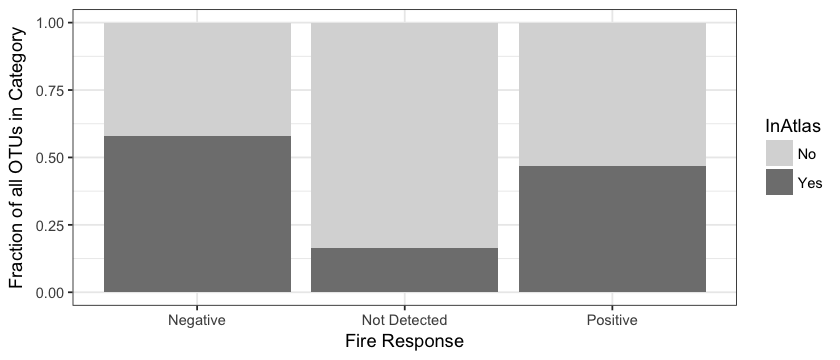

In [34]:
# What fraction of all OTUs are in the atlas?
options(repr.plot.width=7, repr.plot.height=3)

p = ggplot(data=df, aes(x=FireResp,y=Fraction,fill=InAtlas))
p = p + geom_bar(stat="identity",position = "stack")
p = p + theme_bw()
p = p + theme(strip.text.y = element_text(face="italic"))
palette=c("gray85","gray50")
p = p + scale_fill_manual(values=palette)
p = p + scale_color_manual(values=palette)
p = p + ylab("Fraction of all OTUs in Category") + xlab("Fire Response")
#p = p + facet_wrap(~Burned_Unburned, scales="free") + expand_limits(y=0) #+ guides(fill=FALSE)
p

In [35]:
df = mdf.2 %>%
    filter(Burned_Unburned=="Burned")%>%
    #mutate(FireResp = ifelse(is.na(L2FC),"Not Detected",ifelse(L2FC>0,"Positive","Negative")))%>%
    mutate(FireResp = ifelse(is.na(L2FC),"Not Detected","Responder"))%>% 
    mutate(InAtlas = ifelse(is.na(SoilAtlasID),"No","Yes"))%>%
    group_by(FireResp,InAtlas,Sample,Veg_Comm,Land_Class,Severity_Class,Org_or_Min)%>%
    summarize(TotAbund=sum(Abundance))
head(df)

FireResp,InAtlas,Sample,Veg_Comm,Land_Class,Severity_Class,Org_or_Min,TotAbund
Not Detected,No,15S-NT-19O,Treed Wetland,Wetland,Moderate,O,0.2480734
Not Detected,No,15S-NT-20O,Open Wetland,Wetland,Low,O,0.3775012
Not Detected,No,15S-NT-21M,Open Wetland,Wetland,Low,M,0.4142410
Not Detected,No,15S-NT-21O,Open Wetland,Wetland,Low,O,0.4042755
Not Detected,No,15S-NT-22M,Jack Pine,Upland,Moderate,M,0.2292885
Not Detected,No,15S-NT-22O,Jack Pine,Upland,Moderate,O,0.2158301


In [36]:
df  = mdf.2 %>%
    mutate(FireResp = ifelse(is.na(L2FC),"Not Detected",ifelse(L2FC>0,"Positive","Negative")))%>%
    mutate(InAtlas = ifelse(is.na(SoilAtlasID),"No","Yes"))%>%
    group_by(FireResp,InAtlas,Sample)%>%
    summarize(TotAbund = sum(Abundance))%>%
    group_by(FireResp,InAtlas)%>%
    summarize(MeanAbund=mean(TotAbund))%>%
    mutate(RelMeanAbund = MeanAbund/sum(MeanAbund))
df

FireResp,InAtlas,MeanAbund,RelMeanAbund
Negative,No,0.03966227,0.2592580
Negative,Yes,0.11332152,0.7407420
Not Detected,No,0.33910164,0.5503069
Not Detected,Yes,0.27710298,0.4496931
Positive,No,0.08699965,0.3769293
Positive,Yes,0.14381195,0.6230707


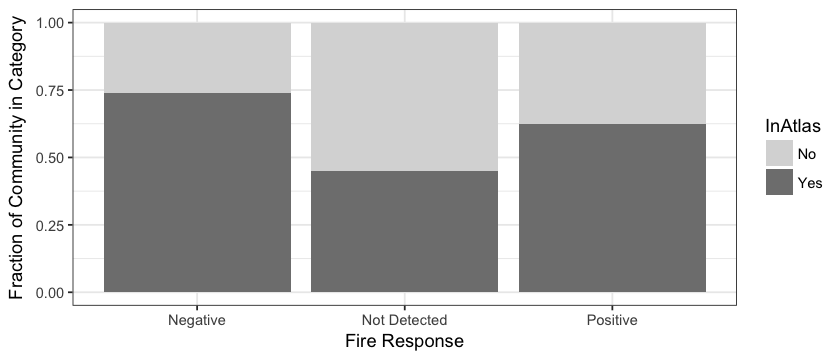

In [37]:
options(repr.plot.width=7, repr.plot.height=3)

p = ggplot(data=df, aes(x=FireResp,y=RelMeanAbund,fill=InAtlas))
p = p + geom_bar(stat="identity",position = "stack")
p = p + theme_bw()
p = p + theme(strip.text.y = element_text(face="italic"))
palette=c("gray85","gray50")
p = p + scale_fill_manual(values=palette)
p = p + scale_color_manual(values=palette)
#p = p + facet_wrap(~Burned_Unburned, scales="free") + expand_limits(y=0) #+ guides(fill=FALSE)
p = p + ylab("Fraction of Community in Category") + xlab("Fire Response")
p

# Now we wonder if the diff in pos vs neg is significant